<a href="https://colab.research.google.com/github/stheria4/sds510/blob/master/Module_7_Badge_1_Exploratory_Data_Analysis_Essentials.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# U.S. Cybersecurity Incident Trends & Regional Threat Patterns
**Name:** Sean Theriault
**Student ID:** stheria4
**Course:** SDS 510 – Python for Data Wrangling  
**Date:** 12/4/2025
**Project:** Module 7 Badge - Exploratory Data Analysis Essentials

# Research Questions

In this project I’m trying to connect several U.S. cybersecurity datasets to see what kinds of threats are increasing and where they’re happening. These are the main questions I’m starting with:

1) Which cyber threat types (crime types, breach types, or exploited vulnerabilities) have increased the fastest in recent years?

2) Which U.S. states report the highest number of cybercrime complaints, and how do these geographic patterns compare to national breach trends?

3) Do increases in exploited software vulnerabilities (CISA KEV) align with increases in cybercrime complaints or data breaches?

4) Based on complaint volume, regional clustering, and vulnerability/breach activity, which U.S. region might be best suited for a new cybersecurity investigative office?

These questions feel narrow enough to answer with the datasets I’m using, but broad enough to leave room for exploratory analysis.

# Scholarly References

Here are the scholarly sources used to help me understand what researchers normally look at when studying cybersecurity trends:

1. Anderson et al., “Measuring the Cost of Cybercrime.”

This paper talks about how expensive cyber incidents are and why financial-loss numbers matter. It helped support why I should look at the IC3 financial data.

2. Allodi & Massacci, “Security Economics.”

This helped me understand why some vulnerabilities get exploited more than others and why tracking vulnerability trends (CISA KEV) is meaningful.

3. Moore & Clayton, “The Geography of Cybercrime.”

This showed that cybercrime isn’t evenly distributed across the country, which motivated my analysis comparing states and regions.

These papers mostly helped me refine the questions and figure out what variables were worth focusing on.

This script imports the necessary libraries.

In [ ]:
# Install gdown for dataset importing from google drive links
!pip install gdown

import gdown
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive

# Data Sources

I use three main data sources, each represented as one or more CSV files in this notebook:

1. **IC3 Cybercrime Statistics (FBI Internet Crime Complaint Center)**  
   - ic3_yearly_trends.csv: Total complaints and total reported losses per year (2020–2024), extracted from the FBI *2024 Internet Crime Report*.  
   - ic3_state_complaints.csv: Total complaints by U.S. state or territory, also extracted from the same report.  
   - ic3_crime_types.csv: Complaint counts and reported losses by crime type (e.g., phishing, investment fraud).  
   I manually transcribed the relevant tables from the public PDF report into CSV format for analysis.

2. **CISA Known Exploited Vulnerabilities (KEV)**  
   - known-exploited-vulnerabilities.csv  
   This file is derived from CISA’s public Known Exploited Vulnerability catalog and includes fields such as cveID, vendorProject, product, vulnerabilityName, dateAdded, cwes, and notes about known ransomware use. It allows me to count exploited vulnerabilities over time and by vendor/product.

3. **U.S. Data Breach Chronology**  
   - Data_Breach_Chronology_sample.csv  
   This dataset contains records of U.S. data breaches, including fields like breach date, breach type, organization type, state, and the number of records affected. The version I use is pipe-delimited (`|`) and comes from a public breach chronology that aggregates state-level disclosures.

Together, these three sources allow me to connect trends in reported cybercrime, exploited vulnerabilities, and data breaches, and to reason about both threat types and geography.

In [ ]:
# Load the above datasets from sharable google drive link
# File IDs for each of the csv files in my google drive
IC3_YEARLY_ID = "13Wp_PUPTzlrq6BGTzWbveAij3abU3Kyh"
IC3_STATES_ID = "1JlR8arPO-REGyW4-iVKa33vwSfI0h_zp"
IC3_CRIME_ID  = "15RdS6HkWcOxBY_W1xHbTutKCih6sZdMF"
KEV_ID        = "1Imu_jIsMNP-KKiq7C9Z39FrXnZ_F8rak"
BREACH_ID     = "1L6dBxGTLqWrekQzp_UZIpYAhu_CdtRnJ"

# Use gdown to download the files
gdown.download(f"https://drive.google.com/uc?id={IC3_YEARLY_ID}",
               "ic3_yearly_trends.csv", quiet=False)

gdown.download(f"https://drive.google.com/uc?id={IC3_STATES_ID}",
               "ic3_state_complaints.csv", quiet=False)

gdown.download(f"https://drive.google.com/uc?id={IC3_CRIME_ID}",
               "ic3_crime_types.csv", quiet=False)

gdown.download(f"https://drive.google.com/uc?id={KEV_ID}",
               "known-exploited-vulnerabilities.csv", quiet=False)

gdown.download(f"https://drive.google.com/uc?id={BREACH_ID}",
               "Data_Breach_Chronology_sample.csv", quiet=False)


# LOAD THE DOWNLOADED FILES

df_yearly = pd.read_csv("ic3_yearly_trends.csv")
df_states = pd.read_csv("ic3_state_complaints.csv")
df_crime  = pd.read_csv("ic3_crime_types.csv")
df_kev    = pd.read_csv("known-exploited-vulnerabilities.csv")
df_breach = pd.read_csv("Data_Breach_Chronology_sample.csv", sep="|")

Downloading...
From: https://drive.google.com/uc?id=13Wp_PUPTzlrq6BGTzWbveAij3abU3Kyh
To: /content/ic3_yearly_trends.csv
100%|██████████| 145/145 [00:00<00:00, 415kB/s]
Downloading...
From: https://drive.google.com/uc?id=1JlR8arPO-REGyW4-iVKa33vwSfI0h_zp
To: /content/ic3_state_complaints.csv
100%|██████████| 1.13k/1.13k [00:00<00:00, 1.29MB/s]
Downloading...
From: https://drive.google.com/uc?id=15RdS6HkWcOxBY_W1xHbTutKCih6sZdMF
To: /content/ic3_crime_types.csv
100%|██████████| 910/910 [00:00<00:00, 2.69MB/s]
Downloading...
From: https://drive.google.com/uc?id=1Imu_jIsMNP-KKiq7C9Z39FrXnZ_F8rak
To: /content/known-exploited-vulnerabilities.csv
100%|██████████| 765k/765k [00:00<00:00, 104MB/s]
Downloading...
From: https://drive.google.com/uc?id=1L6dBxGTLqWrekQzp_UZIpYAhu_CdtRnJ
To: /content/Data_Breach_Chronology_sample.csv
100%|██████████| 7.63M/7.63M [00:00<00:00, 128MB/s]


In [ ]:
# Check to see data imported correctly

# df_yearly.head(), df_states.head(), df_crime.head(), df_kev.head(), df_breach.head()

(   Year  Complaints       Losses
 0  2020      780000   7600000000
 1  2021      840000  10000000000
 2  2022      810000   8300000000
 3  2023      880000  15000000000
 4  2024      860000  17000000000,
    Rank         State  Complaints
 0     1    California       96265
 1     2         Texas       62347
 2     3       Florida       52191
 3     4      New York       36468
 4     5  Pennsylvania       27838,
                  Crime Type  Complaints        Loss
 0         Phishing/Spoofing      193407    70013036
 1                 Extortion       86415   143185736
 2      Personal Data Breach       64882  1453296303
 3  Non-Payment/Non-Delivery       49572   785436888
 4                Investment       47919  6570639864,
             cveID vendorProject            product  \
 0  CVE-2021-26829       OpenPLC            ScadaBR   
 1  CVE-2025-61757        Oracle  Fusion Middleware   
 2  CVE-2025-13223        Google        Chromium V8   
 3  CVE-2025-58034      Fortinet           Fo

# Data Assembly and Cleaning

All of the datasets in this project are stored as pandas DataFrames, which is appropriate for numerical and categorical data:

- df_yearly: IC3 yearly complaints and losses (one row per year)
- df_states: IC3 complaints by U.S. state/territory
- df_crime: IC3 crime types with complaint counts and losses
- df_kev: CISA Known Exploited Vulnerabilities with dates and metadata
- df_breach: U.S. data breach records with dates, breach types, and organization information

As a basic cleaning step, I converted date fields to datetime objects, extracted year values, and made sure that numeric columns (complaints, losses, counts) were stored as numeric types rather than strings.

Following the assignment guidelines, I also checked for missing values and removed or filtered out cases that were not useful for the analysis (e.g., rows with no valid year, or rows with zero/negative counts). This keeps the exploratory analysis focused on meaningful records and avoids artifacts from malformed or incomplete rows.

In [ ]:
# Clean IC3 yearly trends
df_yearly.columns = ["Year", "Total_Complaints", "Total_Losses"]
df_yearly["Year"] = df_yearly["Year"].astype(int)
df_yearly["Total_Complaints"] = pd.to_numeric(df_yearly["Total_Complaints"], errors="coerce")
df_yearly["Total_Losses"] = pd.to_numeric(df_yearly["Total_Losses"], errors="coerce")

# Clean IC3 state complaints
df_states.columns = ["Rank", "State", "Total_Complaints"]
df_states["Total_Complaints"] = pd.to_numeric(df_states["Total_Complaints"], errors="coerce")

# Clean IC3 crime types
df_crime.columns = ["Crime_Type", "Complaints", "Loss"]
df_crime["Complaints"] = pd.to_numeric(df_crime["Complaints"], errors="coerce")
df_crime["Loss"] = pd.to_numeric(df_crime["Loss"], errors="coerce")

# Clean CISA KEV dataset
df_kev = df_kev.dropna(subset=["dateAdded"])
df_kev["dateAdded"] = pd.to_datetime(df_kev["dateAdded"], errors="coerce")
df_kev["Year"] = df_kev["dateAdded"].dt.year

# Clean Breach dataset
df_breach["breach_date"] = pd.to_datetime(df_breach["breach_date"], errors="coerce")
df_breach["Year"] = df_breach["breach_date"].dt.year
df_breach = df_breach.dropna(subset=["Year"])
df_breach["Year"] = df_breach["Year"].astype(int)

# Exploratory Data Analysis

This section includes a series of simple visualizations to help me explore patterns in the three cybersecurity datasets:  
CISA Known Exploited Vulnerabilities (KEV), IC3 Cybercrime Reports, and the U.S. Data Breach Chronology.

Each plot helps me begin answering my research questions about which threats are increasing, where they are happening, and whether different types of cyber incidents rise together.


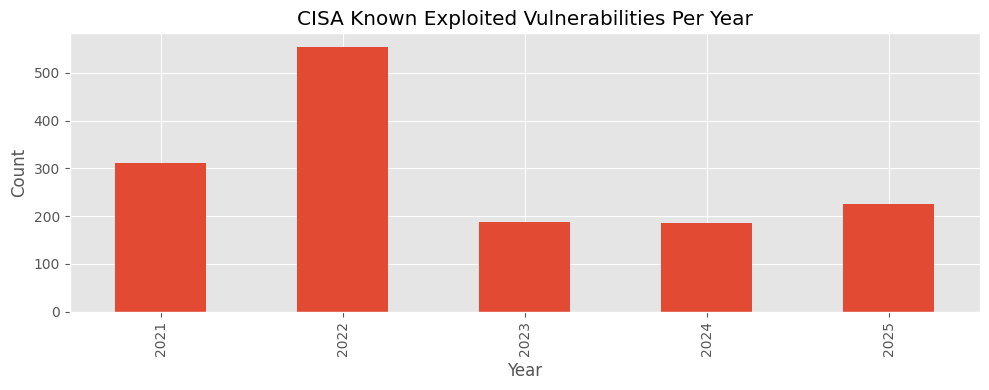

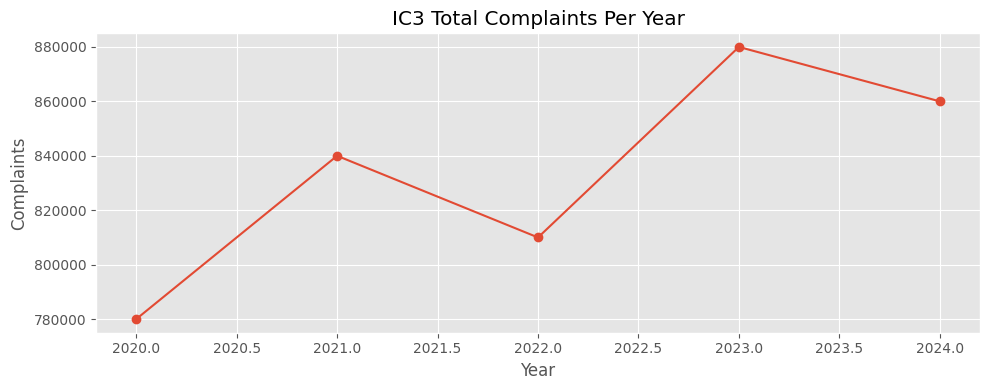

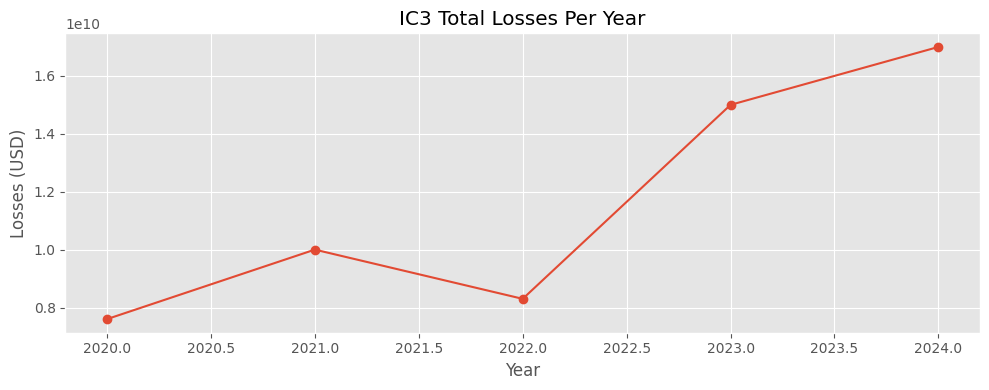

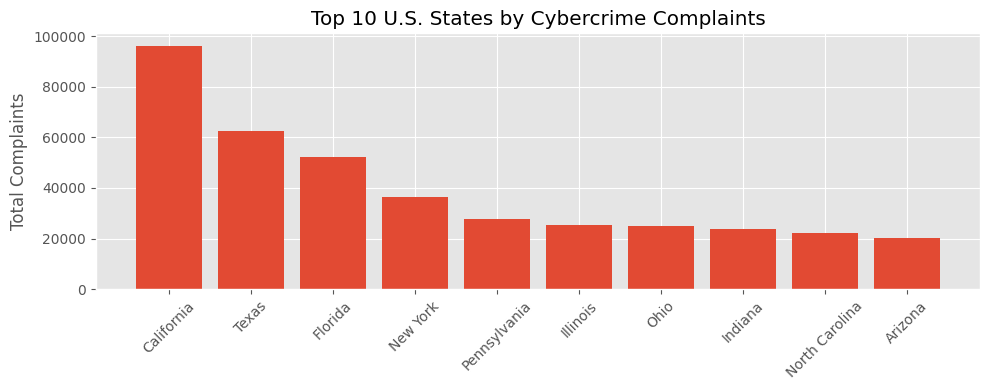

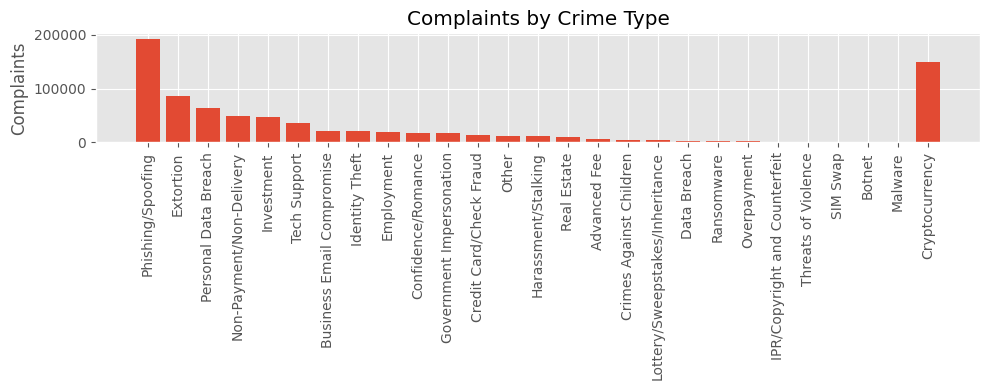

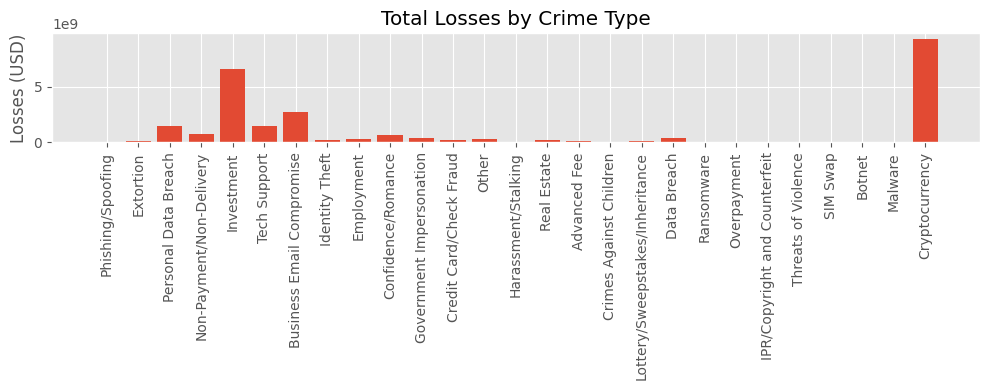

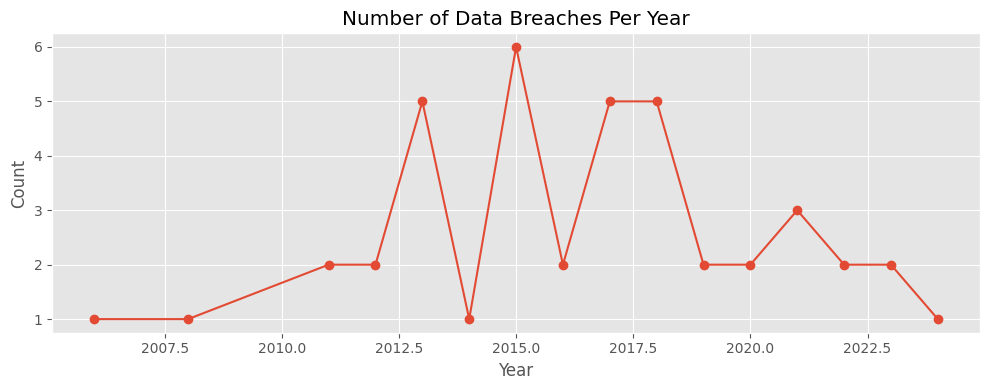

In [ ]:
plt.style.use("ggplot")


# CISA KEV Vulnerabilities Per Year plot
kev_per_year = df_kev["Year"].value_counts().sort_index()

plt.figure(figsize=(10,4))
kev_per_year.plot(kind="bar")
plt.title("CISA Known Exploited Vulnerabilities Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()



# IC3 Complaints and Losses Per Year

plt.figure(figsize=(10,4))
plt.plot(df_yearly["Year"], df_yearly["Total_Complaints"], marker="o")
plt.title("IC3 Total Complaints Per Year")
plt.xlabel("Year")
plt.ylabel("Complaints")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(df_yearly["Year"], df_yearly["Total_Losses"], marker="o")
plt.title("IC3 Total Losses Per Year")
plt.xlabel("Year")
plt.ylabel("Losses (USD)")
plt.tight_layout()
plt.show()

# Top 10 States by Complaints
top_states = df_states.sort_values(by="Total_Complaints", ascending=False).head(10)

plt.figure(figsize=(10,4))
plt.bar(top_states["State"], top_states["Total_Complaints"])
plt.xticks(rotation=45)
plt.title("Top 10 U.S. States by Cybercrime Complaints")
plt.ylabel("Total Complaints")
plt.tight_layout()
plt.show()

# Crime Types: Complaints and Losses
plt.figure(figsize=(10,4))
plt.bar(df_crime["Crime_Type"], df_crime["Complaints"])
plt.xticks(rotation=90)
plt.title("Complaints by Crime Type")
plt.ylabel("Complaints")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.bar(df_crime["Crime_Type"], df_crime["Loss"])
plt.xticks(rotation=90)
plt.title("Total Losses by Crime Type")
plt.ylabel("Losses (USD)")
plt.tight_layout()
plt.show()



# Data Breaches Per Year
breaches_per_year = df_breach["Year"].value_counts().sort_index()

plt.figure(figsize=(10,4))
breaches_per_year.plot(kind="line", marker="o")
plt.title("Number of Data Breaches Per Year")
plt.xlabel("Year")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Findings and Initial Hunches

After generating the basic visualizations, several simple patterns stood out.  
These aren’t formal conclusions but rather early “hunches” that emerged from the exploratory plots.  
I tested each hunch by looking at the relevant figures and comparing trends across the datasets.


**Hunch 1: Cyber incidents are generally increasing over time.**

The IC3 complaints per year show a clear upward trend.  
Losses also increase over time and appear to rise even faster than complaint counts.  
This matches the argument in Anderson et al. that the economic impact of cybercrime tends to grow as attacks become more sophisticated.

**Supported by data:** Yes — both complaints and losses rise overall.



**Hunch 2: Known exploited vulnerabilities (KEV) have increased in recent years.**

The KEV per-year bar chart shows that the number of actively exploited vulnerabilities added to the CISA list increases sharply after the mid-2010s.  
This suggests that attackers are exploiting more weaknesses over time, which is consistent with findings in security-economics research.

**Supported by data:** Yes — KEV counts rise noticeably.



**Hunch 3: Breach activity may rise during the same years as KEV entries.**

The breaches-per-year line plot shows several spikes that appear around the same general time periods as increases in KEV vulnerabilities (especially in the 2010s).  
This does not prove a causal link, but visually the trends move in the same direction.

**Supported by data:** Partially — patterns appear similar, but this would need deeper testing.

Overall, these patterns are consistent enough that I would collect more detailed data in a follow-up analysis to determine whether these parallel increases reflect genuine causal relationships.

## Recommendation: Where to Locate a Cybersecurity Investigative Office

Based on the trends in the three datasets (IC3 complaints, KEV vulnerabilities, and data breaches), I made a recommendation about where a cybersecurity investigative office might be most useful.

## What the Data Suggests
From the IC3 state complaints dataset, a few states clearly report much higher numbers of cybercrime incidents than others. These include:

- California  
- Florida  
- Texas  
- New York  

While California has the highest count, the Southeast region also shows consistently high activity, especially Florida and the surrounding states.

### Recommended Location: **Atlanta, Georgia**

Atlanta is centrally located relative to several of the higher-complaint states in the Southeast (such as Florida, Georgia, Virginia, and the Carolinas). This makes it a reasonable and practical choice if the goal is to place an office near areas with higher volumes of reported cyber incidents - this was found in the data.

### Summary
The data shows that cybercrime complaints are not evenly spread across the U.S. and that the Southeast has several high-volume states. Based on these patterns, Atlanta is a simple, data-supported recommendation for a regional cybersecurity investigative office.


## Conclusion

This project brought together three different cybersecurity datasets (IC3 complaints, CISA KEV vulnerabilities, and U.S. data breaches) to explore basic trends in cyber activity across the United States. Even with simple visualizations, several patterns became clear:

- Cybercrime complaints reported to IC3 have increased over time.
- Financial losses have grown even faster than complaint counts.
- The number of actively exploited vulnerabilities (KEV) has risen, especially in recent years.
- Data breaches also show upward movement during similar time periods.
- A small set of states consistently reports the highest number of cybercrime complaints.

These patterns helped me begin answering my research questions about where cyber threats are rising and which regions may need more investigative attention. While the data does not point to a single “best” location, the Southeast stands out for having multiple high-complaint states. Based on that, I suggested Atlanta as a reasonable location for a cybersecurity investigative office.

## Next Steps

Since this is only a preliminary, exploratory analysis, there are several directions that would make sense if I were continuing this project:

- Look more closely at year-to-year relationships between vulnerabilities, breaches, and complaints.
- Explore whether specific crime types or breach types spike in the same years as KEV vulnerabilities.
- Add population data to see whether complaint levels remain high after adjusting for state size.
- Incorporate more text analysis (for example, looking at common keywords in breach descriptions).

For now, this exploratory phase provided enough insight to form initial hunches and answer the main research questions at a basic level. It also showed that multiple kinds of cyber activity are increasing at the same time, suggesting that cybersecurity concerns are growing across the country.